In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline
plt.style.use("seaborn")
sns.set_context("talk")

In [2]:
df = pd.read_csv("data/Taxicab_Trips_Sampling_in_July_2017.csv")

In [3]:
df = df.loc[df.TOTALAMOUNT>0]
df = df.loc[df.TOTALAMOUNT<1000]
df = df.loc[df.METERFARE>0]
df = df.loc[df.TRIPMILEAGE>0]
df = df.loc[df.TRIPMILEAGE<100]
df = df.loc[df.TRIPTIME>0]
df = df.loc[df.TRIPTIME<120]
df = df.loc[df.TRIPMILEAGE/df.TRIPTIME<2]
df.AIRPORT = df.AIRPORT == "Y"
df["pickup_quadrant"] = df.PICKUP_BLOCKNAME.str.extract(r"\s([NS][EW])\b")
df["dropoff_quadrant"] = df.DROPOFF_BLOCKNAME.str.extract(r"\s([NS][EW])\b")
df["tipping"] = (df.TIP>0) * 1 

df['pickup_datetime'] = pd.to_datetime(df.PICKUPDATETIME_TR)
df['dropoff_datetime'] = pd.to_datetime(df.DROPOFFDATETIME_TR)
df['pickup_date'] = df.pickup_datetime.dt.date
df['pickup_hour'] = df.pickup_datetime.dt.hour
df['dropoff_date'] = df.dropoff_datetime.dt.date
df['dropoff_hour'] = df.dropoff_datetime.dt.hour

df = df.drop(["OBJECTID_1", "OBJECTID"], axis=1)

In [4]:
df.loc[df.DROPOFFSTATE=="Virgin Islands", "DROPOFFSTATE"] = "Virginia"
df.loc[df.PICKUPSTATE=="Virgin Islands", "PICKUPSTATE"] = "Virginia"
df.loc[df.DROPOFFSTATE=="Washington", "DROPOFFSTATE"] = "District of Columbia"
df.loc[df.PICKUPSTATE=="Washington", "PICKUPSTATE"] = "District of Columbia"
df.loc[df.PAYMENTCARDPROVIDER=="Unknown = 0", "PAYMENTCARDPROVIDER"] = np.nan

In [5]:
df.shape

(201887, 36)

In [6]:
df.head()

,TRIPTYPE,PROVIDER,METERFARE,TIP,SURCHARGE,EXTRAS,TOLLS,TOTALAMOUNT,PAYMENTTYPE,PAYMENTCARDPROVIDER,...,DROPOFFDATETIME_TR,pickup_quadrant,dropoff_quadrant,tipping,pickup_datetime,dropoff_datetime,pickup_date,pickup_hour,dropoff_date,dropoff_hour
0,PSP,"Transco, Inc.",3.52,0.00,0.25,21.75,0.0,25.52,CreditCard,VisaCredit,...,2017-07-28T18:00:00.000Z,NE,NE,0,2017-07-28 18:00:00+00:00,2017-07-28 18:00:00+00:00,2017-07-28,18,2017-07-28,18
1,PSP,"Transco, Inc.",5.14,0.00,0.25,0.00,0.0,5.39,Cash,Cash,...,2017-07-28T18:00:00.000Z,NE,NE,0,2017-07-28 18:00:00+00:00,2017-07-28 18:00:00+00:00,2017-07-28,18,2017-07-28,18
2,PSP,"Transco, Inc.",14.32,4.67,0.25,1.00,0.0,20.24,CreditCard,MasterCardCredit,...,2017-07-28T19:00:00.000Z,SW,NW,1,2017-07-28 19:00:00+00:00,2017-07-28 19:00:00+00:00,2017-07-28,19,2017-07-28,19
3,PSP,"Transco, Inc.",4.33,1.12,0.25,1.00,0.0,6.70,CreditCard,MasterCardCredit,...,2017-07-28T19:00:00.000Z,NW,NW,1,2017-07-28 19:00:00+00:00,2017-07-28 19:00:00+00:00,2017-07-28,19,2017-07-28,19
4,PSP,"Transco, Inc.",11.89,0.00,0.25,1.00,0.0,13.14,Cash,Cash,...,2017-07-29T15:00:00.000Z,NW,NW,0,2017-07-29 14:00:00+00:00,2017-07-29 15:00:00+00:00,2017-07-29,14,2017-07-29,15


In [7]:
df.columns

Index(['TRIPTYPE', 'PROVIDER', 'METERFARE', 'TIP', 'SURCHARGE', 'EXTRAS',
       'TOLLS', 'TOTALAMOUNT', 'PAYMENTTYPE', 'PAYMENTCARDPROVIDER',
       'PICKUPCITY', 'PICKUPSTATE', 'PICKUPZIP', 'DROPOFFCITY', 'DROPOFFSTATE',
       'DROPOFFZIP', 'TRIPMILEAGE', 'TRIPTIME', 'PICKUP_BLOCK_LATITUDE',
       'PICKUP_BLOCK_LONGITUDE', 'PICKUP_BLOCKNAME', 'DROPOFF_BLOCK_LATITUDE',
       'DROPOFF_BLOCK_LONGITUDE', 'DROPOFF_BLOCKNAME', 'AIRPORT',
       'PICKUPDATETIME_TR', 'DROPOFFDATETIME_TR', 'pickup_quadrant',
       'dropoff_quadrant', 'tipping', 'pickup_datetime', 'dropoff_datetime',
       'pickup_date', 'pickup_hour', 'dropoff_date', 'dropoff_hour'],
      dtype='object')

In [8]:
df.describe()

,METERFARE,TIP,SURCHARGE,EXTRAS,TOLLS,TOTALAMOUNT,TRIPMILEAGE,TRIPTIME,PICKUP_BLOCK_LATITUDE,PICKUP_BLOCK_LONGITUDE,DROPOFF_BLOCK_LATITUDE,DROPOFF_BLOCK_LONGITUDE,tipping,pickup_hour,dropoff_hour
count,201887.000000,201887.000000,201887.000000,201887.000000,201887.000000,201887.000000,201887.000000,201887.000000,175079.000000,175079.000000,160750.000000,160750.000000,201887.000000,201887.000000,201887.000000
mean,12.260734,1.346732,0.249839,0.646882,0.001129,14.527448,3.213745,13.779124,38.902860,-77.029644,38.904992,-77.029748,0.456121,13.917885,14.005260
std,9.030595,2.220151,0.020152,1.005301,0.098593,10.207571,4.244489,9.310676,0.015010,0.018797,0.016941,0.021433,0.498072,5.335390,5.395488
min,1.000000,0.000000,0.000000,-0.250000,0.000000,3.250000,0.010000,1.000000,38.814661,-77.112057,38.814661,-77.113633,0.000000,0.000000,0.000000
25%,7.300000,0.000000,0.250000,0.000000,0.000000,8.900000,1.000000,8.000000,38.895463,-77.041859,38.896039,-77.042609,0.000000,11.000000,11.000000
50%,10.000000,0.000000,0.250000,0.000000,0.000000,11.870000,2.000000,12.000000,38.900480,-77.031943,38.902520,-77.031140,0.000000,14.000000,14.000000
75%,14.320000,2.200000,0.250000,1.000000,0.000000,16.990000,3.900000,17.000000,38.906453,-77.018731,38.910755,-77.017201,1.000000,18.000000,18.000000
max,223.840000,300.000000,8.720000,49.750000,33.000000,316.650000,95.430000,119.000000,38.991518,-76.911744,38.991518,-76.910927,1.000000,23.000000,23.000000


(38.8, 39.0)

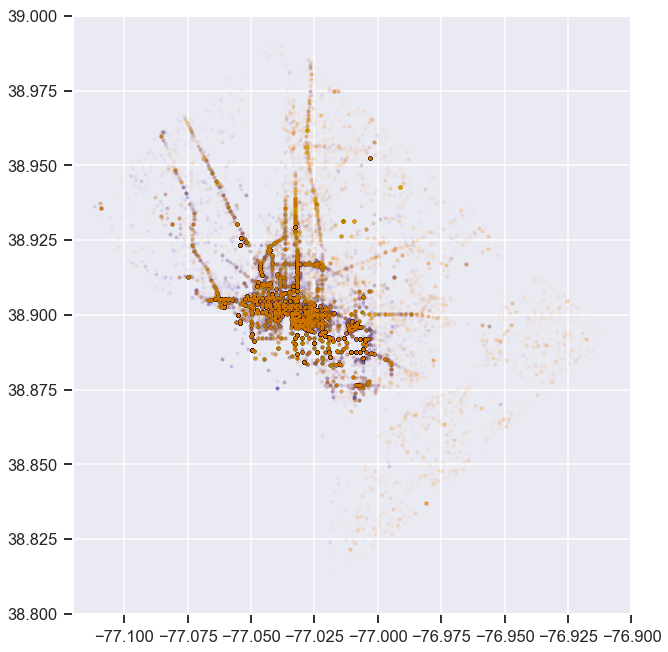

In [9]:
plt.figure(figsize=(10,11))
plt.scatter(df.loc[df.tipping==1].PICKUP_BLOCK_LONGITUDE,
            df.loc[df.tipping==1].PICKUP_BLOCK_LATITUDE, 
            alpha=0.02, 
            s=5,
            c="blue")
plt.scatter(df.loc[df.tipping==0].PICKUP_BLOCK_LONGITUDE,
            df.loc[df.tipping==0].PICKUP_BLOCK_LATITUDE,
            alpha=0.02,
            s=5,
            c="orange" )
plt.xlim(-77.12, -76.90)
plt.ylim(38.80, 39.00)

(38.8, 39.0)

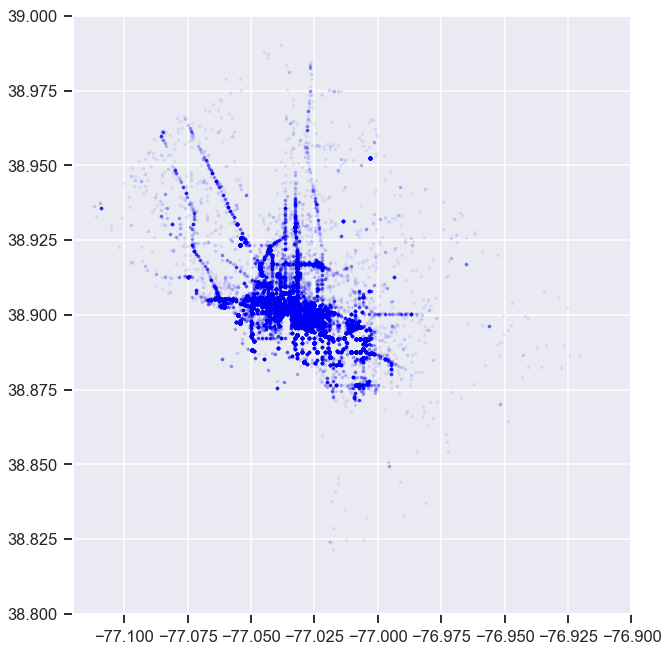

In [10]:
plt.figure(figsize=(10,11))
plt.scatter(df.loc[df.tipping==1].PICKUP_BLOCK_LONGITUDE,
            df.loc[df.tipping==1].PICKUP_BLOCK_LATITUDE, 
            alpha=0.05, 
            s=5,
            c="blue")
plt.xlim(-77.12, -76.90)
plt.ylim(38.80, 39.00)

(38.8, 39.0)

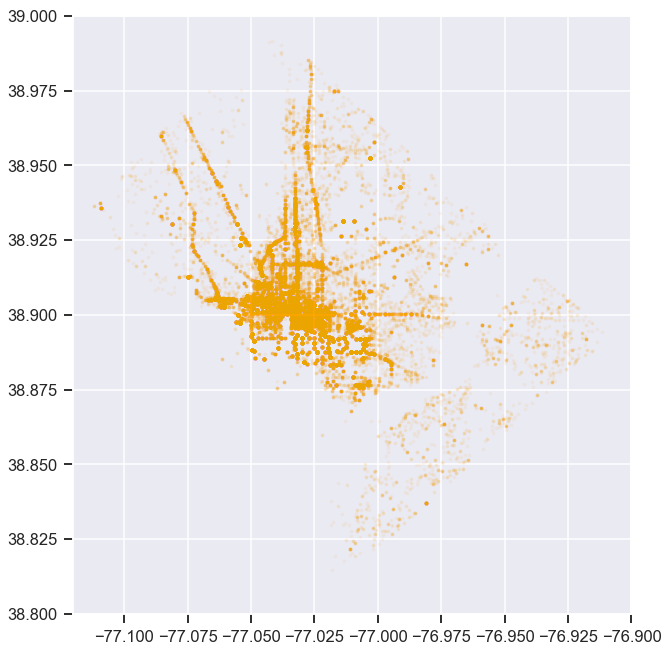

In [11]:
plt.figure(figsize=(10,11))
plt.scatter(df.loc[df.tipping==0].PICKUP_BLOCK_LONGITUDE,
            df.loc[df.tipping==0].PICKUP_BLOCK_LATITUDE,
            alpha=0.05,
            s=5,
            c="orange" )
plt.xlim(-77.12, -76.90)
plt.ylim(38.80, 39.00)

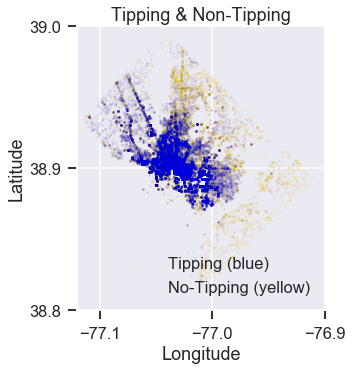

In [176]:
plt.figure(figsize=(5, 5.25))

plt.scatter(df.loc[df.tipping==0].DROPOFF_BLOCK_LONGITUDE,
            df.loc[df.tipping==0].DROPOFF_BLOCK_LATITUDE,
            alpha=0.05,
            s=0.5,
            c="gold")
plt.scatter(df.loc[df.tipping==1].DROPOFF_BLOCK_LONGITUDE,
            df.loc[df.tipping==1].DROPOFF_BLOCK_LATITUDE, 
            alpha=0.05, 
            s=0.5,
            c="blue")

plt.xlim(-77.12, -76.90)
plt.ylim(38.80, 39.00)
plt.title("Tipping & Non-Tipping")
plt.legend(["Tipping (blue)", "No-Tipping (yellow)"], loc=4)

plt.xlabel("Longitude")
plt.xticks([-77.1, -77, -76.9])
plt.ylabel("Latitude")
plt.yticks([38.8, 38.9, 39])
plt.tight_layout()
plt.savefig("image/tipping_map")
plt.show()

(38.8, 39.0)

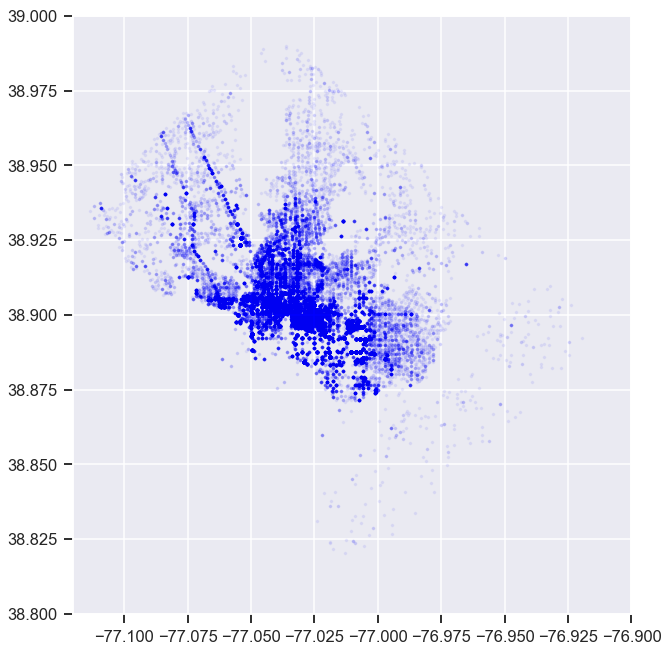

In [13]:
plt.figure(figsize=(10,11))
plt.scatter(df.loc[df.tipping==1].DROPOFF_BLOCK_LONGITUDE,
            df.loc[df.tipping==1].DROPOFF_BLOCK_LATITUDE, 
            alpha=0.05, 
            s=5,
            c="blue")
plt.xlim(-77.12, -76.90)
plt.ylim(38.80, 39.00)

(38.8, 39.0)

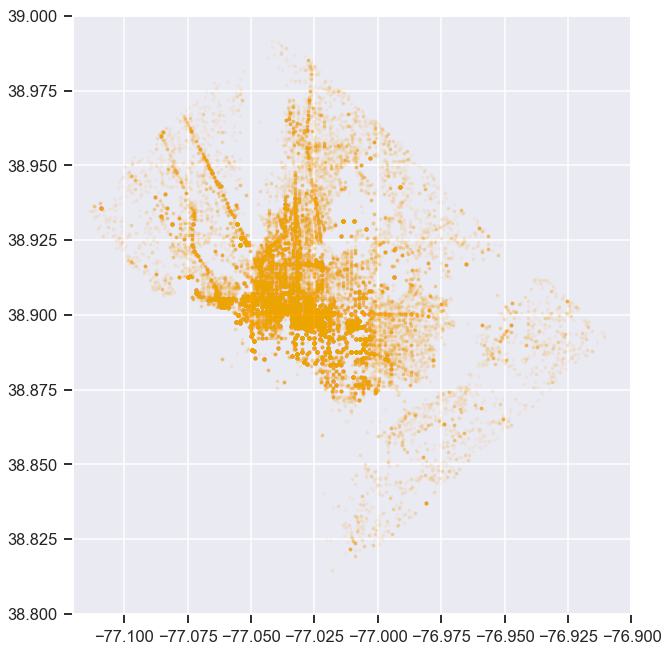

In [14]:
plt.figure(figsize=(10,11))
plt.scatter(df.loc[df.tipping==0].DROPOFF_BLOCK_LONGITUDE,
            df.loc[df.tipping==0].DROPOFF_BLOCK_LATITUDE,
            alpha=0.05,
            s=5,
            c="orange" )
plt.xlim(-77.12, -76.90)
plt.ylim(38.80, 39.00)

In [15]:
df["distance_capitol"] = np.sqrt((df.DROPOFF_BLOCK_LATITUDE-38.8899)**2
                                 +(df.DROPOFF_BLOCK_LONGITUDE+77.0091)**2)

In [16]:
df.TRIPTYPE.value_counts()

PSP             199185
TRANSPORT-DC      1352
DDS               1350
Name: TRIPTYPE, dtype: int64

In [17]:
df.groupby(["TRIPTYPE", "PROVIDER"]).tipping.describe()

count      mean       std  min  25%  50%  \
TRIPTYPE     PROVIDER                                                       
DDS          DCVIP Cab            12.0  0.833333  0.389249  0.0  1.0  1.0   
             United Ventures    1338.0  0.813901  0.389332  0.0  1.0  1.0   
PSP          CMT               45058.0  0.534555  0.498810  0.0  0.0  1.0   
             DCVIP Cab         26099.0  0.721713  0.448164  0.0  0.0  1.0   
             Hitch             28724.0  0.000418  0.020435  0.0  0.0  0.0   
             My Taxi Control    2140.0  0.433645  0.495693  0.0  0.0  0.0   
             Transco, Inc.     25512.0  0.442772  0.496724  0.0  0.0  0.0   
             United Ventures   28884.0  0.540230  0.498388  0.0  0.0  1.0   
             Verifone          26684.0  0.509556  0.499918  0.0  0.0  1.0   
             Yellow Cab of DC  16084.0  0.411900  0.492192  0.0  0.0  0.0   
TRANSPORT-DC Yellow Cab of DC   1352.0  0.001479  0.038447  0.0  0.0  0.0   

                               75%  max  
TRIPTYPE     PROVIDER                    
DDS          DCVIP Cab         1.0  1.0  
             United Ventures   1.0  1.0  
PSP          CMT               1.0  1.0  
             DCVIP Cab         1.0  1.0  
             Hitch             0.0  1.0  
             My Taxi Control   1.0  1.0  
             Transco, Inc.     1.0  1.0  
             United Ventures   1.0  1.0  
             Verifone          1.0  1.0  
             Yellow Cab of DC  1.0  1.0  
TRANSPORT-DC Yellow Cab of DC  0.0  1.0

In [18]:
df["tip_ratio"] = df.TIP / df.METERFARE
df.groupby(["TRIPTYPE", "PROVIDER"]).tip_ratio.describe()

count      mean       std  min       25%  \
TRIPTYPE     PROVIDER                                                       
DDS          DCVIP Cab            12.0  0.216145  0.202886  0.0  0.053765   
             United Ventures    1338.0  0.206918  0.130891  0.0  0.154083   
PSP          CMT               45058.0  0.135856  0.152229  0.0  0.000000   
             DCVIP Cab         26099.0  0.279003  0.459043  0.0  0.000000   
             Hitch             28724.0  0.000097  0.004974  0.0  0.000000   
             My Taxi Control    2140.0  0.101662  0.130620  0.0  0.000000   
             Transco, Inc.     25512.0  0.108919  0.148924  0.0  0.000000   
             United Ventures   28884.0  0.134394  0.151154  0.0  0.000000   
             Verifone          26684.0  0.127419  0.147285  0.0  0.000000   
             Yellow Cab of DC  16084.0  0.105266  0.147407  0.0  0.000000   
TRANSPORT-DC Yellow Cab of DC   1352.0  0.000251  0.007045  0.0  0.000000   

                                    50%       75%        max  
TRIPTYPE     PROVIDER                                         
DDS          DCVIP Cab         0.206242  0.281736   0.615385  
             United Ventures   0.229986  0.260498   1.540832  
PSP          CMT               0.126103  0.238663   5.206654  
             DCVIP Cab         0.224215  0.336323  28.230769  
             Hitch             0.000000  0.000000   0.382653  
             My Taxi Control   0.000000  0.204344   0.841043  
             Transco, Inc.     0.000000  0.212606   6.538462  
             United Ventures   0.129143  0.231244   4.106776  
             Verifone          0.105504  0.227578   3.557692  
             Yellow Cab of DC  0.000000  0.205550   2.469136  
TRANSPORT-DC Yellow Cab of DC  0.000000  0.000000   0.239044

In [19]:
df.sort_values(by="TOTALAMOUNT", ascending=False).head()

,TRIPTYPE,PROVIDER,METERFARE,TIP,SURCHARGE,EXTRAS,TOLLS,TOTALAMOUNT,PAYMENTTYPE,PAYMENTCARDPROVIDER,...,dropoff_quadrant,tipping,pickup_datetime,dropoff_datetime,pickup_date,pickup_hour,dropoff_date,dropoff_hour,distance_capitol,tip_ratio
224035,PSP,DCVIP Cab,15.40,300.00,0.25,1.00,0.0,316.65,CreditCard,VisaCredit,...,SW,1,2017-07-26 17:00:00+00:00,2017-07-26 17:00:00+00:00,2017-07-26,17,2017-07-26,17,0.002758,19.480519
95599,PSP,United Ventures,223.84,48.02,0.25,1.00,15.0,288.11,CreditCard,VisaCredit,...,NaN,1,2017-07-24 08:00:00+00:00,2017-07-24 11:00:00+00:00,2017-07-24,8,2017-07-24,11,NaN,0.214528
22649,PSP,DCVIP Cab,192.52,40.00,0.25,3.00,0.0,235.77,CreditCard,MasterCardCredit,...,NaN,1,2017-07-23 00:00:00+00:00,2017-07-23 01:00:00+00:00,2017-07-23,0,2017-07-23,1,NaN,0.207771
202746,PSP,Yellow Cab of DC,145.81,88.00,0.25,0.25,0.0,234.06,Cash,Cash,...,NW,1,2017-07-24 14:00:00+00:00,2017-07-24 14:00:00+00:00,2017-07-24,14,2017-07-24,14,0.047261,0.603525
55840,PSP,DCVIP Cab,14.86,189.00,0.25,0.00,0.0,204.11,Cash,Cash,...,NW,1,2017-07-26 09:00:00+00:00,2017-07-26 09:00:00+00:00,2017-07-26,9,2017-07-26,9,0.027123,12.718708


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201887 entries, 0 to 228610
Data columns (total 38 columns):
TRIPTYPE                   201887 non-null object
PROVIDER                   201887 non-null object
METERFARE                  201887 non-null float64
TIP                        201887 non-null float64
SURCHARGE                  201887 non-null float64
EXTRAS                     201887 non-null float64
TOLLS                      201887 non-null float64
TOTALAMOUNT                201887 non-null float64
PAYMENTTYPE                201887 non-null object
PAYMENTCARDPROVIDER        201757 non-null object
PICKUPCITY                 158583 non-null object
PICKUPSTATE                163690 non-null object
PICKUPZIP                  170500 non-null object
DROPOFFCITY                147752 non-null object
DROPOFFSTATE               162906 non-null object
DROPOFFZIP                 170258 non-null object
TRIPMILEAGE                201887 non-null float64
TRIPTIME                   20188

In [21]:
df.PICKUPSTATE.value_counts()

District of Columbia    150752
Virginia                 10750
Nebraska                  1274
Maryland                   884
Montana                     17
Connecticut                 10
Delaware                     2
Indiana                      1
Name: PICKUPSTATE, dtype: int64

In [22]:
df.pickup_date.min()

datetime.date(2017, 7, 23)

In [23]:
list(range(23, 31))

[23, 24, 25, 26, 27, 28, 29, 30]

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Taxi Trips in DC')

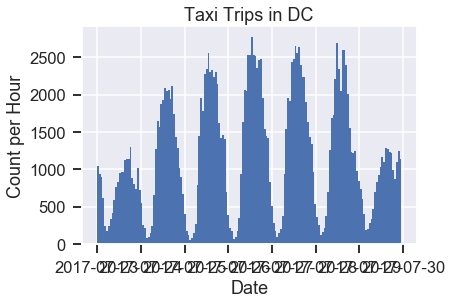

In [24]:
df.pickup_datetime.hist(bins=168)
plt.xlabel("Date")
plt.ylabel("Count per Hour")
plt.title("Taxi Trips in DC")
#plt.xticks(labels=list(range(23, 31)))

In [25]:
formula = "TOTALAMOUNT ~ TRIPMILEAGE + TRIPTIME"
model = smf.ols(formula, df).fit(cov_type="HC1")
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TOTALAMOUNT   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                 5.419e+04
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        11:21:09   Log-Likelihood:            -5.4319e+05
No. Observations:              201887   AIC:                         1.086e+06
Df Residuals:                  201884   BIC:                         1.086e+06
Df Model:                           2                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.7501      0.033    144.177      0.000       4.686       4.815
TRIPMILEAGE     1.7656      0.012    145.595      0.000       1.742       1.789
TRIPTIME        0.2978      0.004     72.059      0.000       0.290       0.306
==============================================================================
Omnibus:                   213661.948   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1074587715.899
Skew:                           3.984   Prob(JB):                         0.00
Kurtosis:                     360.326   Cond. No.                         31.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

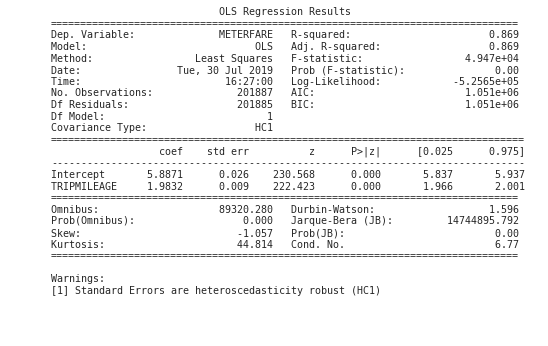

In [193]:
formula = "METERFARE ~ TRIPMILEAGE"
model = smf.ols(formula, df).fit(cov_type="HC1")
model.summary()

plt.rc('figure', figsize=(8, 5))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('image/ols_meterfare_tripmileage')

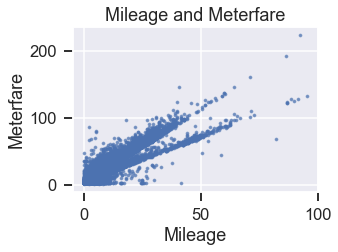

In [143]:
plt.figure(figsize=(4.8, 3.6))
plt.scatter(df.TRIPMILEAGE, 
            df.METERFARE, 
            s=5, 
            alpha=0.6)
plt.xlabel("Mileage")
plt.ylabel("Meterfare")
plt.title("Mileage and Meterfare")
plt.tight_layout()
plt.savefig("image/meterfare_all")
plt.show()

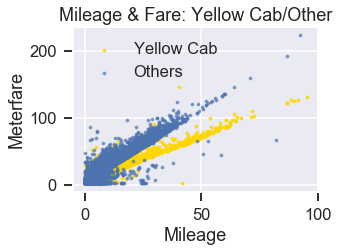

In [169]:
plt.figure(figsize=(4.8, 3.6))
plt.scatter(df.loc[df.PROVIDER=="Yellow Cab of DC"].TRIPMILEAGE, 
            df.loc[df.PROVIDER=="Yellow Cab of DC"].METERFARE, 
            s=5, 
            alpha=0.8,
            c = "gold")
plt.scatter(df.loc[df.PROVIDER!="Yellow Cab of DC"].TRIPMILEAGE, 
            df.loc[df.PROVIDER!="Yellow Cab of DC"].METERFARE, 
            s=5, 
            alpha=0.6)
plt.xlabel("Mileage")
plt.ylabel("Meterfare")
plt.title("Mileage & Fare: Yellow Cab/Other")
plt.legend(["Yellow Cab", "Others"])
plt.tight_layout()
plt.savefig("image/meterfare_yellowcab")
plt.show()

In [200]:
formula = "METERFARE ~ TRIPMILEAGE * C(PROVIDER)"
model = smf.ols(formula, df).fit(cov_type="HC1")
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              METERFARE   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                 2.679e+04
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        16:58:57   Log-Likelihood:            -4.8283e+05
No. Observations:              201887   AIC:                         9.657e+05
Df Residuals:                  201871   BIC:                         9.659e+05
Df Model:                          15                                         
Covariance Type:                  HC1                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       5.3921      0.021    259.896      0.000       5.351       5.433
C(PROVIDER)[T.DCVIP Cab]                       -0.6738      0.038    -17.612      0.000      -0.749      -0.599
C(PROVIDER)[T.Hitch]                            0.7056      0.038     18.666      0.000       0.632       0.780
C(PROVIDER)[T.My Taxi Control]                  0.2618      0.104      2.506      0.012       0.057       0.467
C(PROVIDER)[T.Transco, Inc.]                    0.0161      0.090      0.179      0.858      -0.160       0.193
C(PROVIDER)[T.United Ventures]                 -0.0527      0.027     -1.947      0.052      -0.106       0.000
C(PROVIDER)[T.Verifone]                         0.0419      0.049      0.856      0.392      -0.054       0.138
C(PROVIDER)[T.Yellow Cab of DC]                 0.5734      0.039     14.594      0.000       0.496       0.650
TRIPMILEAGE                                     2.2173      0.007    296.850      0.000       2.203       2.232
TRIPMILEAGE:C(PROVIDER)[T.DCVIP Cab]           -0.0114      0.015     -0.778      0.436      -0.040       0.017
TRIPMILEAGE:C(PROVIDER)[T.Hitch]                0.1969      0.014     14.479      0.000       0.170       0.224
TRIPMILEAGE:C(PROVIDER)[T.My Taxi Control]      0.0705      0.031      2.289      0.022       0.010       0.131
TRIPMILEAGE:C(PROVIDER)[T.Transco, Inc.]        0.0044      0.032      0.137      0.891      -0.058       0.067
TRIPMILEAGE:C(PROVIDER)[T.United Ventures]     -0.0037      0.009     -0.390      0.697      -0.022       0.015
TRIPMILEAGE:C(PROVIDER)[T.Verifone]            -0.0072      0.018     -0.387      0.698      -0.043       0.029
TRIPMILEAGE:C(PROVIDER)[T.Yellow Cab of DC]    -0.8048      0.010    -82.019      0.000      -0.824      -0.786
==============================================================================
Omnibus:                    75791.305   Durbin-Watson:                   1.715
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         55008090.938
Skew:                          -0.144   Prob(JB):                         0.00
Kurtosis:                      83.865   Cond. No.                         73.6
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

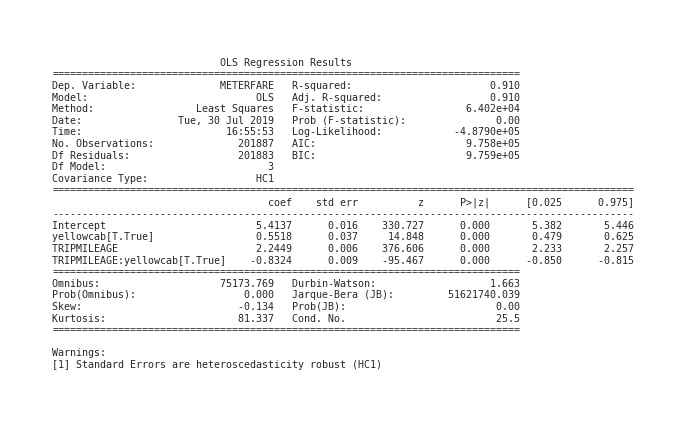

In [199]:
df["yellowcab"] = df.PROVIDER == "Yellow Cab of DC"
formula = "METERFARE ~ TRIPMILEAGE * yellowcab"
model = smf.ols(formula, df).fit(cov_type="HC1")
model.summary()
plt.rc('figure', figsize=(10, 6))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('image/ols_meterfare_tripmileage_yellowcab')

In [30]:
formula = "TRIPMILEAGE ~ TRIPTIME"
model = smf.ols(formula, df).fit(cov_type="HC1")
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TRIPMILEAGE   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                 1.250e+04
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        11:21:21   Log-Likelihood:            -5.1944e+05
No. Observations:              201887   AIC:                         1.039e+06
Df Residuals:                  201885   BIC:                         1.039e+06
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9621      0.032    -29.826      0.000      -1.025      -0.899
TRIPTIME       0.3031      0.003    111.788      0.000       0.298       0.308
==============================================================================
Omnibus:                   182657.786   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20295642.919
Skew:                           3.945   Prob(JB):                         0.00
Kurtosis:                      51.481   Cond. No.                         29.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [31]:
formula = "TIP ~ METERFARE"
model = smf.ols(formula, df.loc[df.tipping==1]).fit(cov_type="HC1")
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    TIP   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     7128.
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        11:21:21   Log-Likelihood:            -1.9446e+05
No. Observations:               92085   AIC:                         3.889e+05
Df Residuals:                   92083   BIC:                         3.889e+05
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9796      0.022     44.118      0.000       0.936       1.023
METERFARE      0.1622      0.002     84.427      0.000       0.158       0.166
==============================================================================
Omnibus:                   299579.455   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     161593849271.110
Skew:                          54.506   Prob(JB):                         0.00
Kurtosis:                    6491.769   Cond. No.                         25.6
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

(0, 50)

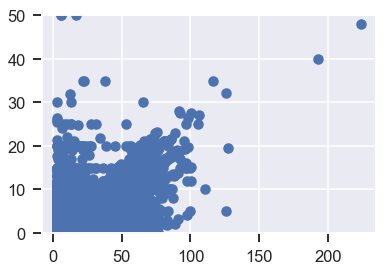

In [32]:
plt.scatter(df.loc[df.tipping==1].METERFARE, df.loc[df.tipping==1].TIP)
plt.ylim(0,50)

In [33]:
formula = "TIP ~ METERFARE + C(PROVIDER) + AIRPORT + C(PAYMENTTYPE) + C(pickup_date) + C(pickup_hour)"
model = smf.ols(formula, df.loc[df.tipping==1]).fit(cov_type="HC1")
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    TIP   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     466.7
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        11:21:25   Log-Likelihood:            -1.9370e+05
No. Observations:               92085   AIC:                         3.875e+05
Df Residuals:                   92044   BIC:                         3.879e+05
Df Model:                          40                                         
Covariance Type:                  HC1                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        1.3729      0.076     17.952      0.000       1.223       1.523
C(PROVIDER)[T.DCVIP Cab]                         0.3194      0.042      7.642      0.000       0.237       0.401
C(PROVIDER)[T.Hitch]                            -0.6360      0.206     -3.090      0.002      -1.039      -0.233
C(PROVIDER)[T.My Taxi Control]                  -0.4711      0.061     -7.751      0.000      -0.590      -0.352
C(PROVIDER)[T.Transco, Inc.]                    -0.0297      0.013     -2.233      0.026      -0.056      -0.004
C(PROVIDER)[T.United Ventures]                  -0.0230      0.013     -1.727      0.084      -0.049       0.003
C(PROVIDER)[T.Verifone]                         -0.0326      0.012     -2.671      0.008      -0.057      -0.009
C(PROVIDER)[T.Yellow Cab of DC]                 -0.2766      0.057     -4.895      0.000      -0.387      -0.166
AIRPORT[T.True]                                  0.4298      0.030     14.413      0.000       0.371       0.488
C(PAYMENTTYPE)[T.CreditCard]                    -0.2916      0.053     -5.476      0.000      -0.396      -0.187
C(PAYMENTTYPE)[T.Voucher]                       -0.7106      0.087     -8.142      0.000      -0.882      -0.540
C(pickup_date)[T.datetime.date(2017, 7, 24)]    -0.0400      0.028     -1.430      0.153      -0.095       0.015
C(pickup_date)[T.datetime.date(2017, 7, 25)]    -0.0560      0.025     -2.205      0.027      -0.106      -0.006
C(pickup_date)[T.datetime.date(2017, 7, 26)]    -0.0200      0.031     -0.637      0.524      -0.082       0.042
C(pickup_date)[T.datetime.date(2017, 7, 27)]    -0.0484      0.026     -1.832      0.067      -0.100       0.003
C(pickup_date)[T.datetime.date(2017, 7, 28)]    -0.0773      0.026     -2.987      0.003      -0.128      -0.027
C(pickup_date)[T.datetime.date(2017, 7, 29)]     0.0154      0.039      0.395      0.693      -0.061       0.091
C(pickup_hour)[T.1]                              0.0324      0.139      0.233      0.816      -0.240       0.305
C(pickup_hour)[T.2]                              0.0231      0.139      0.166      0.868      -0.250       0.296
C(pickup_hour)[T.3]                             -0.1882      0.088     -2.130      0.033      -0.361      -0.015
C(pickup_hour)[T.4]                             -0.3103      0.105     -2.949      0.003      -0.517      -0.104
C(pickup_hour)[T.5]                             -0.2584      0.108     -2.400      0.016      -0.469      -0.047
C(pickup_hour)[T.6]                             -0.2165      0.073     -2.976      0.003      -0.359      -0.074
C(pickup_hour)[T.7]                             -0.1619      0.059     -2.736      0.006      -0.278      -0.046
C(pickup_hour)[T.8]             

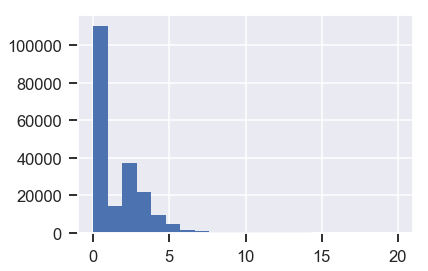

In [34]:
df.loc[df.TIP<20].TIP.hist(bins=21)

In [93]:
formula = "tipping ~ TRIPMILEAGE + C(PROVIDER) + AIRPORT + C(PAYMENTTYPE) + C(pickup_date) + C(pickup_hour) + C(TRIPTYPE)"
model = smf.logit(formula, df).fit(cov_type="HC1")
model.summary()

Optimization terminated successfully.
         Current function value: 0.219983
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                tipping   No. Observations:               201887
Model:                          Logit   Df Residuals:                   201844
Method:                           MLE   Df Model:                           42
Date:                Tue, 30 Jul 2019   Pseudo R-squ.:                  0.6809
Time:                        12:40:56   Log-Likelihood:                -44412.
converged:                       True   LL-Null:                   -1.3916e+05
                                        LLR p-value:                     0.000
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -4.1265      0.173    -23.887      0.000      -4.465      -3.788
C(PROVIDER)[T.DCVIP Cab]                         4.5195      0.050     90.237      0.000       4.421       4.618
C(PROVIDER)[T.Hitch]                            -9.7123      0.291    -33.336      0.000     -10.283      -9.141
C(PROVIDER)[T.My Taxi Control]                   3.9853      0.061     65.317      0.000       3.866       4.105
C(PROVIDER)[T.Transco, Inc.]                    -0.7639      0.034    -22.357      0.000      -0.831      -0.697
C(PROVIDER)[T.United Ventures]                   0.1650      0.034      4.836      0.000       0.098       0.232
C(PROVIDER)[T.Verifone]                         -0.6305      0.033    -18.841      0.000      -0.696      -0.565
C(PROVIDER)[T.Yellow Cab of DC]                  4.0279      0.046     88.475      0.000       3.939       4.117
AIRPORT[T.True]                                  0.5078      0.031     16.126      0.000       0.446       0.569
C(PAYMENTTYPE)[T.CreditCard]                     7.1309      0.049    145.593      0.000       7.035       7.227
C(PAYMENTTYPE)[T.Voucher]                        6.4571      0.246     26.280      0.000       5.976       6.939
C(pickup_date)[T.datetime.date(2017, 7, 24)]     0.3773      0.036     10.601      0.000       0.308       0.447
C(pickup_date)[T.datetime.date(2017, 7, 25)]     0.5061      0.035     14.511      0.000       0.438       0.574
C(pickup_date)[T.datetime.date(2017, 7, 26)]     0.5629      0.034     16.330      0.000       0.495       0.630
C(pickup_date)[T.datetime.date(2017, 7, 27)]     0.5506      0.034     16.039      0.000       0.483       0.618
C(pickup_date)[T.datetime.date(2017, 7, 28)]     0.3088      0.035      8.887      0.000       0.241       0.377
C(pickup_date)[T.datetime.date(2017, 7, 29)]    -0.0431      0.038     -1.134      0.257      -0.118       0.031
C(pickup_hour)[T.1]                             -0.1733      0.094     -1.843      0.065      -0.358       0.011
C(pickup_hour)[T.2]                             -0.1714      0.096     -1.777      0.076      -0.361       0.018
C(pickup_hour)[T.3]                             -0.3079      0.116     -2.645      0.008      -0.536      -0.080
C(pickup_hour)[T.4]                             -0.6470      0.127     -5.078      0.000      -0.897      -0.397
C(pickup_hour)[T.5]                             -0.5017      0.118     -4.246      0.000      -0.733      -0.270
C(pickup_hour)[T.6]                             -0.4755      0.095     -5.030      0.000      -0.661      -0.290
C(pickup_hour)[T.7]                             -0.3364      0.077     -4.379      0.000      -0.487      -0.186
C(pickup_hour)[T.8]                             -0.1694      0.071     -2.397      0.017      -0.308      -0.031
C(pickup_hour)[T.9]                             -0.0118      0.068     -0.173

In [96]:
formula = "tipping ~ TRIPMILEAGE + C(PROVIDER) + AIRPORT + C(PAYMENTTYPE) + C(pickup_date) + C(pickup_hour) + C(TRIPTYPE) + C(dropoff_quadrant)"
model = smf.logit(formula, df).fit(cov_type="HC1")
model.summary()

Optimization terminated successfully.
         Current function value: 0.210563
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                tipping   No. Observations:               159046
Model:                          Logit   Df Residuals:                   159000
Method:                           MLE   Df Model:                           45
Date:                Tue, 30 Jul 2019   Pseudo R-squ.:                  0.6942
Time:                        12:44:23   Log-Likelihood:                -33489.
converged:                       True   LL-Null:                   -1.0950e+05
                                        LLR p-value:                     0.000
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -4.2047      0.195    -21.590      0.000      -4.586      -3.823
C(PROVIDER)[T.DCVIP Cab]                         4.6614      0.058     80.513      0.000       4.548       4.775
C(PROVIDER)[T.Hitch]                            -9.9460      0.356    -27.901      0.000     -10.645      -9.247
C(PROVIDER)[T.My Taxi Control]                   4.0549      0.069     58.702      0.000       3.920       4.190
C(PROVIDER)[T.Transco, Inc.]                    -0.8186      0.040    -20.676      0.000      -0.896      -0.741
C(PROVIDER)[T.United Ventures]                   0.1441      0.039      3.677      0.000       0.067       0.221
C(PROVIDER)[T.Verifone]                         -0.6813      0.039    -17.346      0.000      -0.758      -0.604
C(PROVIDER)[T.Yellow Cab of DC]                  4.1714      0.054     77.956      0.000       4.066       4.276
AIRPORT[T.True]                                  0.4433      0.051      8.670      0.000       0.343       0.543
C(PAYMENTTYPE)[T.CreditCard]                     7.2866      0.057    127.485      0.000       7.175       7.399
C(PAYMENTTYPE)[T.Voucher]                        6.6418      0.281     23.657      0.000       6.092       7.192
C(pickup_date)[T.datetime.date(2017, 7, 24)]     0.3695      0.042      8.827      0.000       0.287       0.452
C(pickup_date)[T.datetime.date(2017, 7, 25)]     0.4829      0.041     11.732      0.000       0.402       0.564
C(pickup_date)[T.datetime.date(2017, 7, 26)]     0.5332      0.041     13.103      0.000       0.453       0.613
C(pickup_date)[T.datetime.date(2017, 7, 27)]     0.5273      0.041     12.984      0.000       0.448       0.607
C(pickup_date)[T.datetime.date(2017, 7, 28)]     0.2814      0.041      6.867      0.000       0.201       0.362
C(pickup_date)[T.datetime.date(2017, 7, 29)]    -0.0894      0.045     -2.001      0.045      -0.177      -0.002
C(pickup_hour)[T.1]                             -0.1685      0.108     -1.561      0.118      -0.380       0.043
C(pickup_hour)[T.2]                             -0.1224      0.113     -1.079      0.281      -0.345       0.100
C(pickup_hour)[T.3]                             -0.2182      0.153     -1.430      0.153      -0.517       0.081
C(pickup_hour)[T.4]                             -0.9475      0.211     -4.484      0.000      -1.362      -0.533
C(pickup_hour)[T.5]                             -1.1125      0.206     -5.395      0.000      -1.517      -0.708
C(pickup_hour)[T.6]                             -0.7457      0.126     -5.918      0.000      -0.993      -0.499
C(pickup_hour)[T.7]                             -0.3899      0.090     -4.337      0.000      -0.566      -0.214
C(pickup_hour)[T.8]                             -0.1223      0.082     -1.498      0.134      -0.282       0.038
C(pickup_hour)[T.9]                              0.0032      0.078      0.041

In [97]:
formula = "tipping ~ TRIPMILEAGE + C(PROVIDER) + AIRPORT + C(PAYMENTTYPE) + C(pickup_date) + C(pickup_hour) + C(TRIPTYPE) + C(dropoff_quadrant) + distance_capitol"
model = smf.logit(formula, df).fit(cov_type="HC1")
model.summary()

Optimization terminated successfully.
         Current function value: 0.209817
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                tipping   No. Observations:               159046
Model:                          Logit   Df Residuals:                   158999
Method:                           MLE   Df Model:                           46
Date:                Tue, 30 Jul 2019   Pseudo R-squ.:                  0.6952
Time:                        12:44:42   Log-Likelihood:                -33371.
converged:                       True   LL-Null:                   -1.0950e+05
                                        LLR p-value:                     0.000
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -4.0330      0.194    -20.795      0.000      -4.413      -3.653
C(PROVIDER)[T.DCVIP Cab]                         4.6719      0.058     80.490      0.000       4.558       4.786
C(PROVIDER)[T.Hitch]                            -9.9691      0.357    -27.961      0.000     -10.668      -9.270
C(PROVIDER)[T.My Taxi Control]                   4.0536      0.069     58.580      0.000       3.918       4.189
C(PROVIDER)[T.Transco, Inc.]                    -0.8144      0.040    -20.547      0.000      -0.892      -0.737
C(PROVIDER)[T.United Ventures]                   0.1451      0.039      3.702      0.000       0.068       0.222
C(PROVIDER)[T.Verifone]                         -0.6800      0.039    -17.285      0.000      -0.757      -0.603
C(PROVIDER)[T.Yellow Cab of DC]                  4.1510      0.053     77.643      0.000       4.046       4.256
AIRPORT[T.True]                                  0.3637      0.051      7.185      0.000       0.264       0.463
C(PAYMENTTYPE)[T.CreditCard]                     7.2863      0.057    127.229      0.000       7.174       7.399
C(PAYMENTTYPE)[T.Voucher]                        6.6465      0.280     23.761      0.000       6.098       7.195
C(pickup_date)[T.datetime.date(2017, 7, 24)]     0.3568      0.042      8.505      0.000       0.275       0.439
C(pickup_date)[T.datetime.date(2017, 7, 25)]     0.4649      0.041     11.261      0.000       0.384       0.546
C(pickup_date)[T.datetime.date(2017, 7, 26)]     0.5093      0.041     12.489      0.000       0.429       0.589
C(pickup_date)[T.datetime.date(2017, 7, 27)]     0.5055      0.041     12.422      0.000       0.426       0.585
C(pickup_date)[T.datetime.date(2017, 7, 28)]     0.2722      0.041      6.630      0.000       0.192       0.353
C(pickup_date)[T.datetime.date(2017, 7, 29)]    -0.0900      0.045     -2.009      0.045      -0.178      -0.002
C(pickup_hour)[T.1]                             -0.1717      0.108     -1.590      0.112      -0.383       0.040
C(pickup_hour)[T.2]                             -0.1189      0.114     -1.043      0.297      -0.342       0.105
C(pickup_hour)[T.3]                             -0.2085      0.154     -1.353      0.176      -0.511       0.094
C(pickup_hour)[T.4]                             -0.9573      0.208     -4.601      0.000      -1.365      -0.549
C(pickup_hour)[T.5]                             -1.1465      0.205     -5.589      0.000      -1.549      -0.744
C(pickup_hour)[T.6]                             -0.8144      0.126     -6.467      0.000      -1.061      -0.568
C(pickup_hour)[T.7]                             -0.4610      0.090     -5.112      0.000      -0.638      -0.284
C(pickup_hour)[T.8]                             -0.1906      0.082     -2.323      0.020      -0.351      -0.030
C(pickup_hour)[T.9]                             -0.0705      0.079     -0.893

In [98]:
formula = "tipping ~ TRIPMILEAGE + C(PROVIDER) + AIRPORT + C(PAYMENTTYPE) + C(pickup_date) + C(pickup_hour) + C(TRIPTYPE) + C(dropoff_quadrant) * distance_capitol"
model = smf.logit(formula, df).fit(cov_type="HC1")
model.summary()

Optimization terminated successfully.
         Current function value: 0.208811
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                tipping   No. Observations:               159046
Model:                          Logit   Df Residuals:                   158996
Method:                           MLE   Df Model:                           49
Date:                Tue, 30 Jul 2019   Pseudo R-squ.:                  0.6967
Time:                        12:54:27   Log-Likelihood:                -33211.
converged:                       True   LL-Null:                   -1.0950e+05
                                        LLR p-value:                     0.000
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -3.6222      0.197    -18.406      0.000      -4.008      -3.236
C(PROVIDER)[T.DCVIP Cab]                         4.6767      0.058     80.550      0.000       4.563       4.791
C(PROVIDER)[T.Hitch]                            -9.9734      0.357    -27.974      0.000     -10.672      -9.275
C(PROVIDER)[T.My Taxi Control]                   4.0447      0.069     58.484      0.000       3.909       4.180
C(PROVIDER)[T.Transco, Inc.]                    -0.7965      0.040    -20.032      0.000      -0.874      -0.719
C(PROVIDER)[T.United Ventures]                   0.1422      0.039      3.629      0.000       0.065       0.219
C(PROVIDER)[T.Verifone]                         -0.6817      0.039    -17.304      0.000      -0.759      -0.605
C(PROVIDER)[T.Yellow Cab of DC]                  4.1631      0.053     77.873      0.000       4.058       4.268
AIRPORT[T.True]                                  0.3490      0.050      6.916      0.000       0.250       0.448
C(PAYMENTTYPE)[T.CreditCard]                     7.2818      0.057    127.095      0.000       7.170       7.394
C(PAYMENTTYPE)[T.Voucher]                        6.6581      0.279     23.833      0.000       6.111       7.206
C(pickup_date)[T.datetime.date(2017, 7, 24)]     0.3602      0.042      8.569      0.000       0.278       0.443
C(pickup_date)[T.datetime.date(2017, 7, 25)]     0.4633      0.041     11.184      0.000       0.382       0.544
C(pickup_date)[T.datetime.date(2017, 7, 26)]     0.5042      0.041     12.330      0.000       0.424       0.584
C(pickup_date)[T.datetime.date(2017, 7, 27)]     0.5042      0.041     12.353      0.000       0.424       0.584
C(pickup_date)[T.datetime.date(2017, 7, 28)]     0.2798      0.041      6.787      0.000       0.199       0.361
C(pickup_date)[T.datetime.date(2017, 7, 29)]    -0.0910      0.045     -2.028      0.043      -0.179      -0.003
C(pickup_hour)[T.1]                             -0.1684      0.109     -1.538      0.124      -0.383       0.046
C(pickup_hour)[T.2]                             -0.1222      0.115     -1.065      0.287      -0.347       0.103
C(pickup_hour)[T.3]                             -0.1934      0.156     -1.239      0.215      -0.500       0.113
C(pickup_hour)[T.4]                             -0.9689      0.211     -4.584      0.000      -1.383      -0.555
C(pickup_hour)[T.5]                             -1.2092      0.207     -5.848      0.000      -1.614      -0.804
C(pickup_hour)[T.6]                             -0.8683      0.126     -6.900      0.000      -1.115      -0.622
C(pickup_hour)[T.7]                             -0.4984      0.090     -5.523      0.000      -0.675      -0.322
C(pickup_hour)[T.8]                             -0.2289      0.082     -2.777      0.005      -0.390      -0.067
C(pickup_hour)[T.9]                             -0.1062      0.079     -1.338

In [124]:
hypothesis = "-distance_capitol = C(dropoff_quadrant)[T.NW]:distance_capitol"

In [125]:
model.f_test(hypothesis)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[62.81339386]]), p=2.2870685172902255e-15, df_denom=158996, df_num=1>

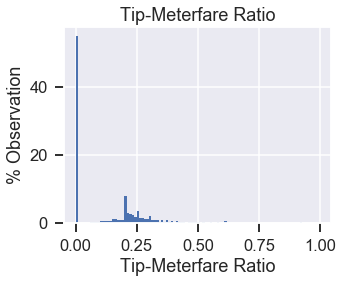

In [90]:
plt.figure(figsize=(4.8, 3.6))
df.loc[df.tip_ratio<1].tip_ratio.hist(bins=100, density=True)
plt.title("Tip-Meterfare Ratio")
plt.xlabel("Tip-Meterfare Ratio")
plt.ylabel("% Observation")

plt.savefig("image/tip-meterfare_hist")
plt.show()

In [87]:
df.tipping.mean()

0.4561214937068756

In [89]:
df.loc[(df.tip_ratio<1)&(df.tip_ratio>0)].tip_ratio.describe()

count    91116.000000
mean         0.263364
std          0.124485
min          0.000137
25%          0.203029
50%          0.232143
75%          0.300000
max          0.996923
Name: tip_ratio, dtype: float64

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


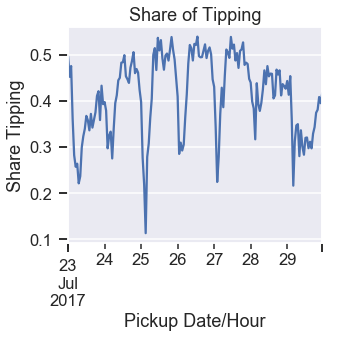

In [178]:
plt.figure(figsize=(4.8, 4.8))
df.groupby("pickup_datetime").tipping.mean().plot()
plt.title("Share of Tipping")
plt.ylabel("Share Tipping")
plt.xlabel("Pickup Date/Hour")

plt.tight_layout()
plt.savefig("image/tipping_overtime")
plt.show()

In [39]:
ts_tipping = df.groupby("pickup_datetime").tipping.mean()

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


<Figure size 432x288 with 0 Axes>

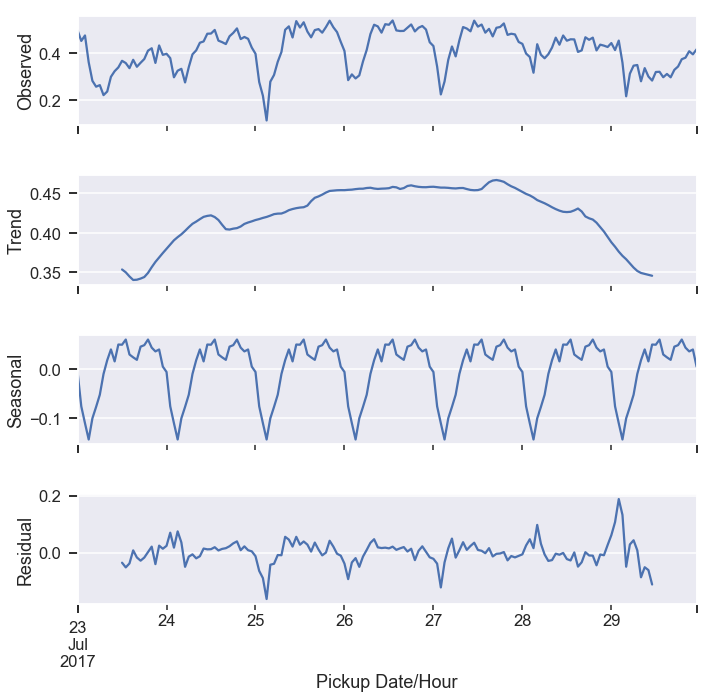

In [184]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_tipping, freq=24)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.xlabel("Pickup Date/Hour")
plt.tight_layout()
plt.savefig("image/time_series_decomposition")
plt.show()

In [41]:
from statsmodels.tsa.stattools import adfuller
pd.Series(adfuller(ts_tipping, autolag='AIC')[0:4], 
          index=['Test Statistic',
                 'p-value',
                 '#Lags Used',
                 'Number of Observations Used'])


Test Statistic                  -4.833536
p-value                          0.000047
#Lags Used                       4.000000
Number of Observations Used    163.000000
dtype: float64

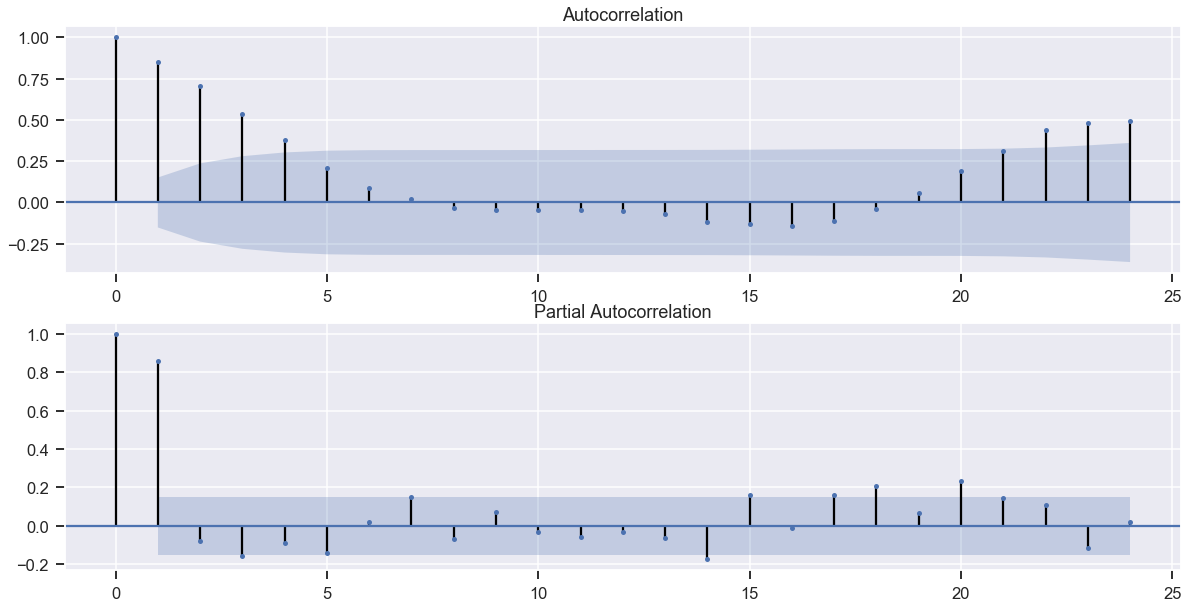

In [42]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(ts_tipping, lags=24, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ts_tipping, lags=24, ax=ax[1])
plt.show()

In [43]:
# resDiff = sm.tsa.arma_order_select_ic(ts_tipping, max_ar=6, max_ma=3, ic='aic', trend='c')
# print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

In [62]:
sarima = sm.tsa.statespace.SARIMAX(ts_tipping,
                                  order=(4, 1, 2),
                                  freq='H',
                                  seasonal_order=(1, 1, 1, 24),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False).fit()
sarima.summary()

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            tipping   No. Observations:                  168
Model:             SARIMAX(4, 1, 2)x(1, 1, 1, 24)   Log Likelihood                 161.408
Date:                            Tue, 30 Jul 2019   AIC                           -304.817
Time:                                    11:39:41   BIC                           -280.112
Sample:                                07-23-2017   HQIC                          -294.789
                                     - 07-29-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5095      0.181     -8.330      0.000      -1.865      -1.154
ar.L2         -1.6776      0.200     -8.375      0.000      -2.070      -1.285
ar.L3         -1.6379      0.201     -8.155      0.000      -2.032      -1.244
ar.L4         -0.8952      0.106     -8.472      0.000      -1.102      -0.688
ma.L1          3.0775      1.007      3.056      0.002       1.104       5.052
ma.L2          2.9744      1.105      2.691      0.007       0.808       5.141
ar.S.L24       0.0427      0.102      0.417      0.677      -0.158       0.244
ma.S.L24      -0.1374      0.164     -0.838      0.402      -0.459       0.184
sigma2         0.0004      0.000      1.309      0.190      -0.000       0.001
===================================================================================
Ljung-Box (Q):                       56.57   Jarque-Bera (JB):                20.96
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                            -0.46
Prob(H) (two-sided):                  0.38   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

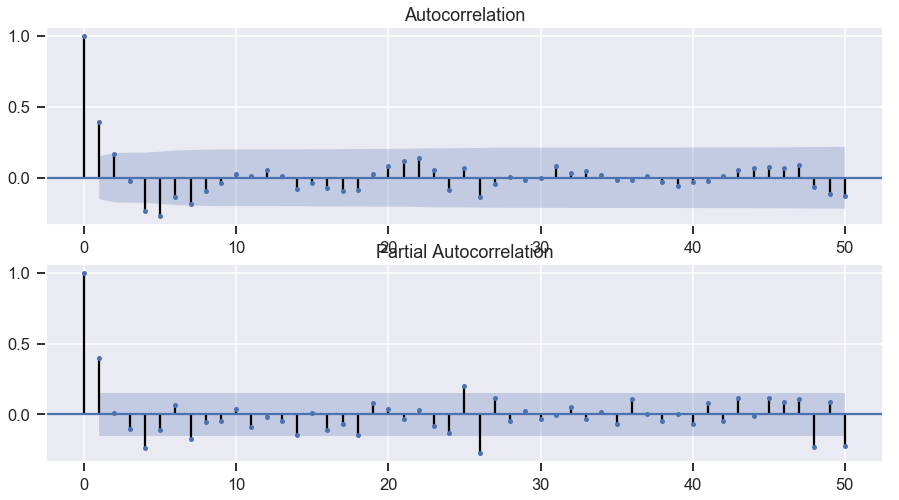

In [63]:
res = sarima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [64]:
pred = sarima.predict()

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


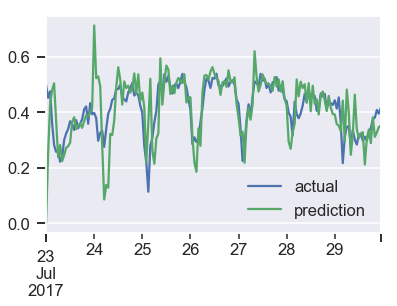

In [65]:
pd.DataFrame({'actual':ts_tipping,'prediction':pred}).plot()
plt.show()

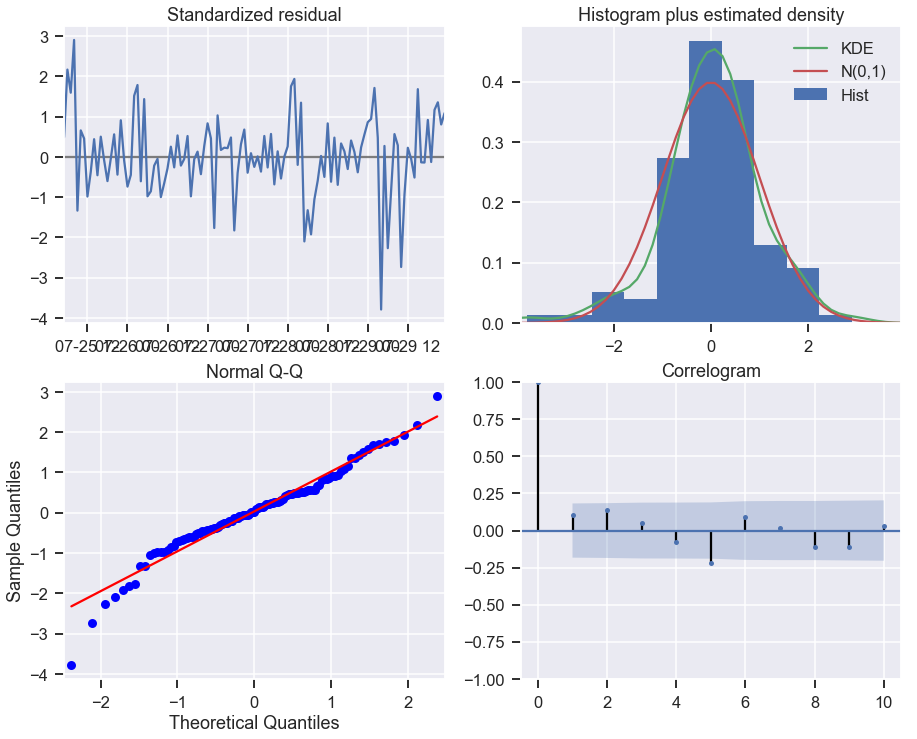

In [66]:
sarima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [55]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 5
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = [4, 1, 2]

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

In [56]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []

for combs in pdqs:
    try:
        mod = sm.tsa.statespace.SARIMAX(ts_tipping,
                                        order=pdq,
                                        seasonal_order=combs,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        output = mod.fit()
        ans.append([pdq, combs, output.aic])
        print('SARIMA {} x {} : AIC Calculated ={}'.format(pdq, combs, output.aic))
    except:
        continue

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


SARIMA [4, 1, 2] x (0, 0, 0, 24) : AIC Calculated =-525.6789711999903


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


SARIMA [4, 1, 2] x (0, 0, 1, 24) : AIC Calculated =-396.4152787169211


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA [4, 1, 2] x (0, 0, 2, 24) : AIC Calculated =4978.788736639931


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


SARIMA [4, 1, 2] x (0, 1, 0, 24) : AIC Calculated =-420.9454055429752


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA [4, 1, 2] x (0, 1, 1, 24) : AIC Calculated =-320.76428275358336


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA [4, 1, 2] x (0, 2, 0, 24) : AIC Calculated =395.0988352746188


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA [4, 1, 2] x (0, 2, 1, 24) : AIC Calculated =302.24405144498155


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


SARIMA [4, 1, 2] x (1, 0, 0, 24) : AIC Calculated =-457.57081251439564


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA [4, 1, 2] x (1, 0, 1, 24) : AIC Calculated =-449.39983385287


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA [4, 1, 2] x (1, 0, 2, 24) : AIC Calculated =5046.129918916232


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA [4, 1, 2] x (1, 1, 0, 24) : AIC Calculated =-338.59350051505675


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA [4, 1, 2] x (1, 1, 1, 24) : AIC Calculated =-304.8167597748998


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA [4, 1, 2] x (1, 2, 0, 24) : AIC Calculated =295.0729064970112


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA [4, 1, 2] x (1, 2, 1, 24) : AIC Calculated =273.57946563437747


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA [4, 1, 2] x (2, 0, 0, 24) : AIC Calculated =-333.74351360506415


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA [4, 1, 2] x (2, 0, 1, 24) : AIC Calculated =-382.5588742422424


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA [4, 1, 2] x (2, 0, 2, 24) : AIC Calculated =4730.732075116285


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA [4, 1, 2] x (2, 1, 0, 24) : AIC Calculated =-234.80800503478062


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA [4, 1, 2] x (2, 1, 1, 24) : AIC Calculated =-219.45634714743613


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA [4, 1, 2] x (2, 2, 0, 24) : AIC Calculated =16.18093816146684


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA [4, 1, 2] x (2, 2, 1, 24) : AIC Calculated =2.891510605752689


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [54]:
# # Find the parameters with minimal AIC value.
# ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
# ans_df.loc[ans_df['aic'].idxmin()]